# I] Import + user-defined variables

In [1]:
import pandas, numpy, math, seaborn
import scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt
# this is a trick to make figures look nicer
matplotlib.rcParams.update({'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                            'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',
                            'figure.figsize':(12, 8), 'svg.fonttype' : 'none'})

## functions & options


In [2]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'

In [3]:
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

# II] Dataframe download and settings

In [4]:
%%time
# DL data GABARAP isoform expression
path = output_file_directory + "/GABARAP/dataframes_for_input/df_GABARAP_NormPrim.csv"
df_GABARAP_NormPrim= pandas.read_csv(path, sep = ",")

df_GABARAP_NormPrim = df_GABARAP_NormPrim.rename(columns = {'GABARAP_total' : 'GABARAP_all_tpm'})

#Add columns, normalized on total
df_GABARAP_NormPrim = df_GABARAP_NormPrim.assign(GABARAP_1lognorm= df_GABARAP_NormPrim['GABARAP_1']/df_GABARAP_NormPrim["GABARAP"],
                                                 GABARAP_2lognorm= df_GABARAP_NormPrim['GABARAP_2']/df_GABARAP_NormPrim["GABARAP"],
                                                 GABARAP_3lognorm= df_GABARAP_NormPrim['GABARAP_3']/df_GABARAP_NormPrim["GABARAP"])

print(df_GABARAP_NormPrim.shape)
df_GABARAP_NormPrim.head(2)

(16614, 25)
Wall time: 120 ms


,sample,Sample_Type,Primary_Site,GABARAP,GABARAP_1,GABARAP_2,GABARAP_3,GABARAP_all_tpm,GABARAP_1tpm,GABARAP_2tpm,...,GABARAP_prot_tot,GABARAP_1perc,GABARAP_2perc,GABARAP_3perc,GABARAP_1norm,GABARAP_2norm,GABARAP_3norm,GABARAP_1lognorm,GABARAP_2lognorm,GABARAP_3lognorm
0,GTEX-OIZI-0005-SM-2XCED,Normal Tissue,Blood,11.27,7.823,9.316,10.4,2469.493431,226.441351,637.374609,...,2214.991061,10.223127,28.775493,61.001379,0.091695,0.258099,0.547147,0.694144,0.826619,0.922804
1,GTEX-XAJ8-0006-SM-46MVM,Normal Tissue,Blood,11.24,6.587,9.797,10.4,2418.671971,96.134675,889.590998,...,2336.900774,4.113768,38.067128,57.819105,0.039747,0.367801,0.558643,0.586032,0.871619,0.925267


In [5]:
#Download the filtered sample list
path = "samples_IDs/filtered_samples_list"

samples_list_normal= numpy.loadtxt(input_file_directory+path+'_normal.tsv', delimiter="\t", dtype=str)
samples_list_primary= numpy.loadtxt(input_file_directory+path+'_primary.tsv', delimiter="\t", dtype=str)

print(len(samples_list_normal), len(samples_list_primary))

5903 8022


In [6]:
# NormPrim with the filtered tissues
filtered_samples_list = list(samples_list_normal) + list(samples_list_primary)
df_GABARAP_NormPrim = df_GABARAP_NormPrim.loc[df_GABARAP_NormPrim['sample'].isin(filtered_samples_list)]
print('normal_tissue' , df_GABARAP_NormPrim.shape)

normal_tissue (13925, 25)


In [7]:
#Creation of two dataframe, Normal tissue and Primary tumor.
df_GABARAP_Normal = df_GABARAP_NormPrim.loc[df_GABARAP_NormPrim['sample'].isin(samples_list_normal)]
df_GABARAP_Primary = df_GABARAP_NormPrim.loc[df_GABARAP_NormPrim['sample'].isin(samples_list_primary)]

print('normal_tissue' , df_GABARAP_Normal.shape)
print('primary_tumors' , df_GABARAP_Primary.shape)

normal_tissue (5903, 25)
primary_tumors (8022, 25)


# III] GABARAP expression

In [8]:
# df with only Normal and percentage
df_sampletype= df_GABARAP_Normal[['Primary_Site',
                               'GABARAP_prot_tot',             
                               'GABARAP_1perc',
                               'GABARAP_2perc',
                               'GABARAP_3perc']]

df_sampletype = df_sampletype.assign(GABARAP_3perc = df_sampletype['GABARAP_3perc'].abs(),
                                     GABARAP_2perc = df_sampletype['GABARAP_2perc'].abs())
#Column rename
df_sampletype = df_sampletype.rename(columns = {'Primary_Site' : 'Primary Site', 
                                                'GABARAP_total': 'tpm GABARAP(all)',
                                                'GABARAP_1perc' : "% GABARAP(1)",
                                                'GABARAP_2perc' : "% GABARAP(2)",
                                                'GABARAP_3perc' : "% GABARAP(3)"})

#Groupby to have merge of all the primary site 
df_sampletype= df_sampletype.groupby('Primary Site').agg(numpy.mean)

df_sampletype.head()

,GABARAP_prot_tot,% GABARAP(1),% GABARAP(2),% GABARAP(3)
Primary Site,,,,
Adipose Tissue,579.665024,4.268756,33.532687,62.198557
Adrenal Gland,687.660318,3.023200,29.123580,67.853221
Bladder,575.418506,3.911816,35.536096,60.552088
Blood,1029.870435,4.548531,37.047484,58.403985
Blood Vessel,736.307388,4.354190,34.710374,60.935436


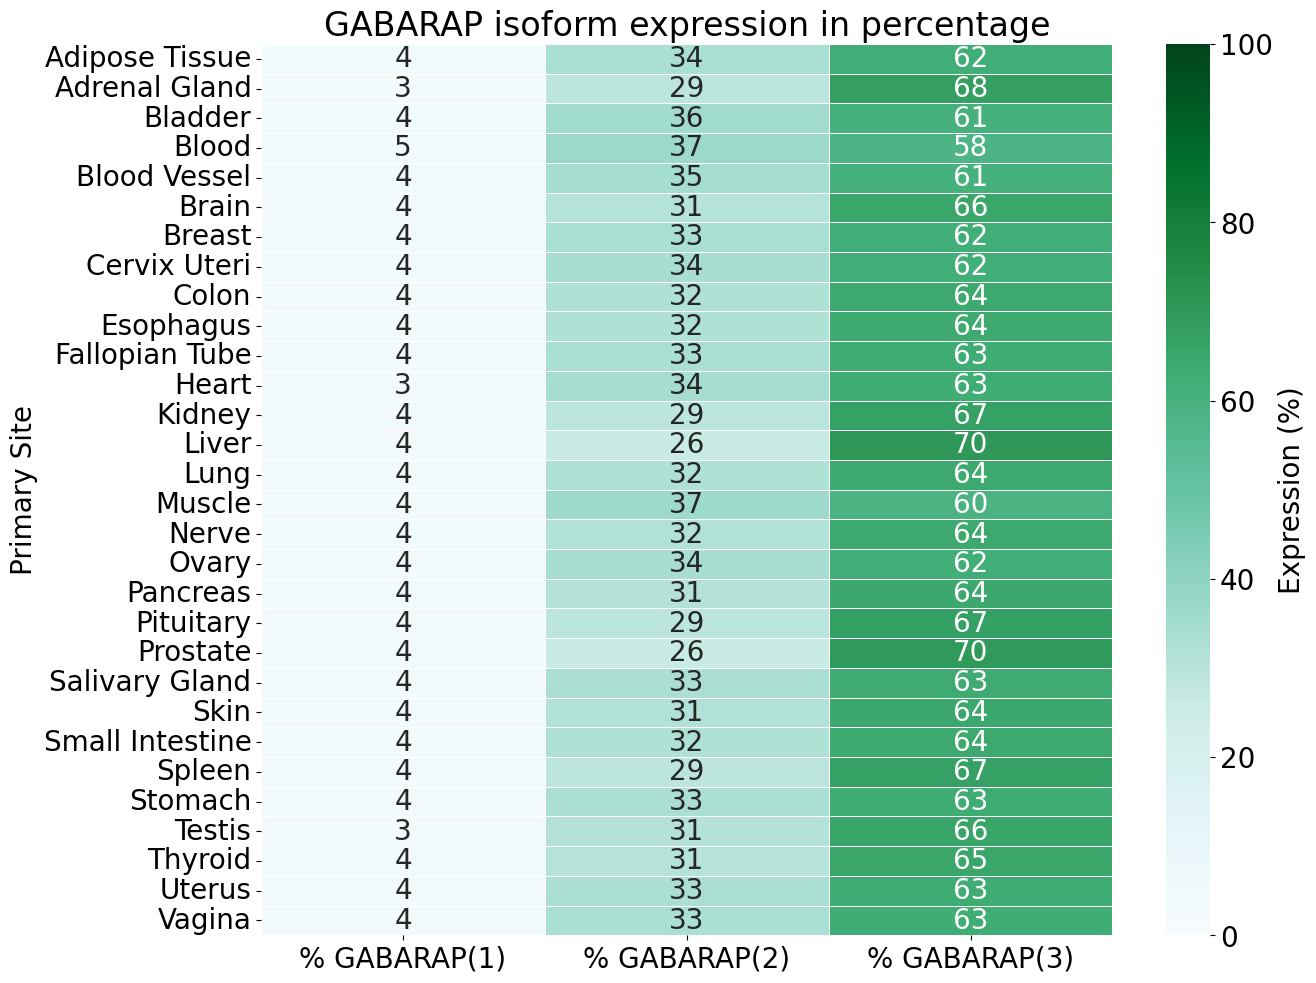

In [9]:
#heatmap percentage
plt.subplots(figsize=(12,10))
plt.tight_layout()

HeatMap_df_sampletype = df_sampletype[['% GABARAP(1)', '% GABARAP(2)', '% GABARAP(3)']]
seaborn.heatmap(HeatMap_df_sampletype, annot=True, cmap="BuGn", linewidths=.5,
                vmin = 0, vmax = 100,
                xticklabels=True, yticklabels=True, fmt='.0f',
                cbar_kws={'label': 'Expression (%)'})
plt.title('GABARAP isoform expression in percentage')

path = 'GABARAP/figs_GABARAP_characterisation/'
plt.savefig(output_file_directory+path+'heatmap_organs.svg')

plt.show()

In [10]:
# df with only Normal 
hist_df_sampletype = df_sampletype.reset_index()
hist_df_sampletype = hist_df_sampletype[['Primary Site','GABARAP_prot_tot']]
hist_df_sampletype.head()

,Primary Site,GABARAP_prot_tot
0,Adipose Tissue,579.665024
1,Adrenal Gland,687.660318
2,Bladder,575.418506
3,Blood,1029.870435
4,Blood Vessel,736.307388


In [11]:
df_tissues = df_GABARAP_Normal[['Primary_Site',
                             'GABARAP_all_tpm']]

##Column rename
df_tissues = df_tissues.rename(columns = {'Primary_Site' : 'Primary Site', 
                                          'GABARAPl_tpm': 'tpm GABARAPl',
                                          'GABARAPl_1tpm': 'tpm GABARAPl(1)',
                                          'GABARAPl_2tpm': 'tpm GABARAPl(2)'})
df_tissues = df_tissues.sort_values('Primary Site')
df_tissues.head(2)

,Primary Site,GABARAP_all_tpm
4549,Adipose Tissue,503.901219
4149,Adipose Tissue,535.223371


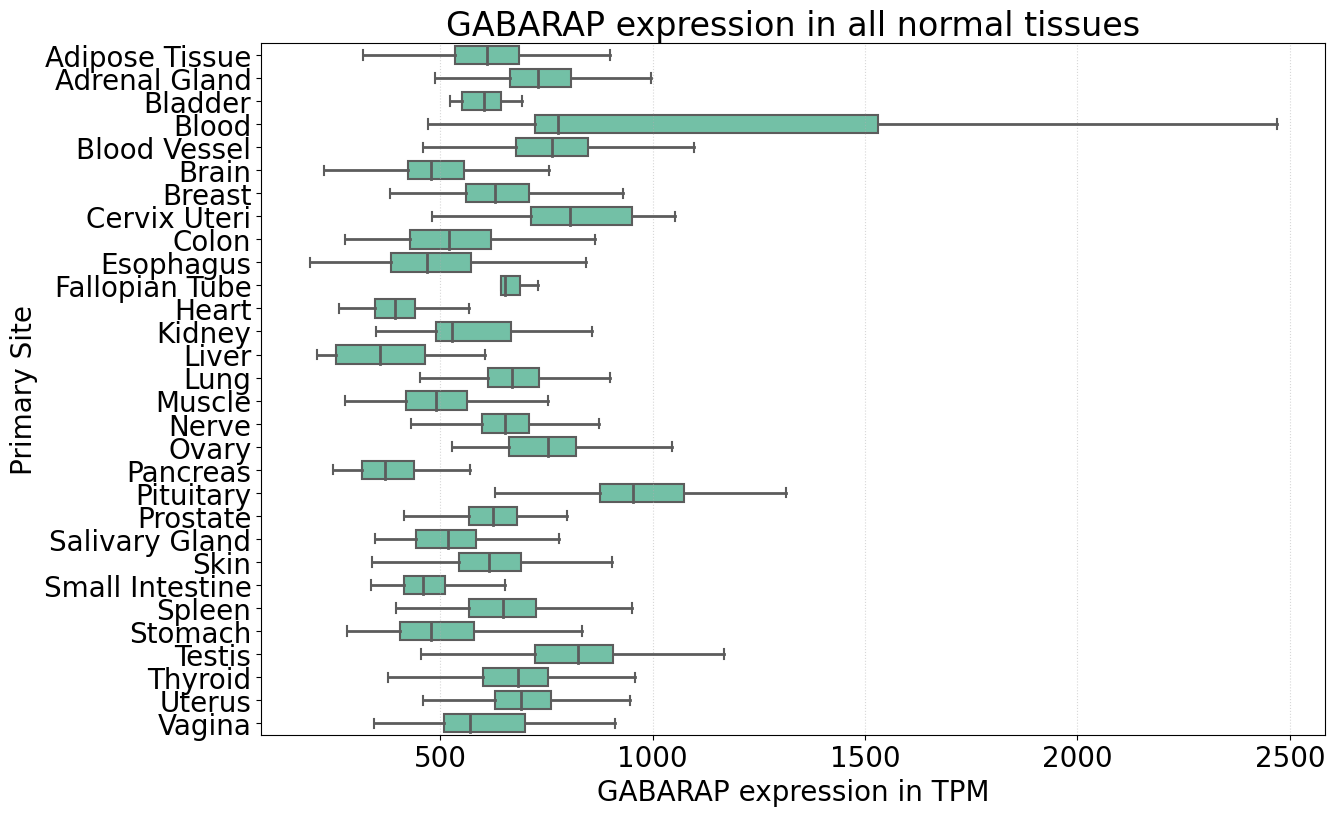

In [12]:
plt.subplots()
plt.tight_layout()

seaborn.boxplot(data = df_tissues, x =  'GABARAP_all_tpm', y = 'Primary Site', 
                medianprops={'lw':2}, whiskerprops={'lw':2}, 
                showcaps=True, showfliers=False,
                color = 'mediumaquamarine')

plt.title('GABARAP expression in all normal tissues')
plt.xlabel('GABARAP expression in TPM')


path = 'GABARAP/figs_GABARAP_characterisation/'
plt.savefig(output_file_directory+path+'barplot_tpm.svg')

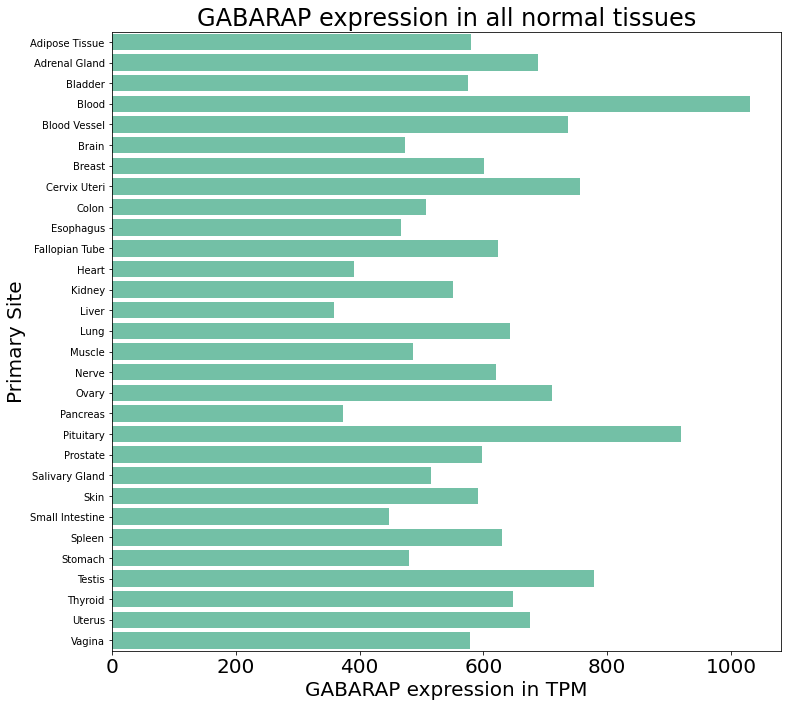

In [13]:
# Seaborn
seaborn.barplot(data = hist_df_sampletype, x =  'GABARAP_prot_tot', y = 'Primary Site', color = 'mediumaquamarine')
plt.title('GABARAP expression in all normal tissues')
plt.xlabel('GABARAP expression in TPM')
plt.subplots_adjust(top=1.2)

path = 'GABARAP/figs_GABARAP_characterisation/'
plt.savefig(output_file_directory+path+'barplot_tpm.svg')

## A) Distribution

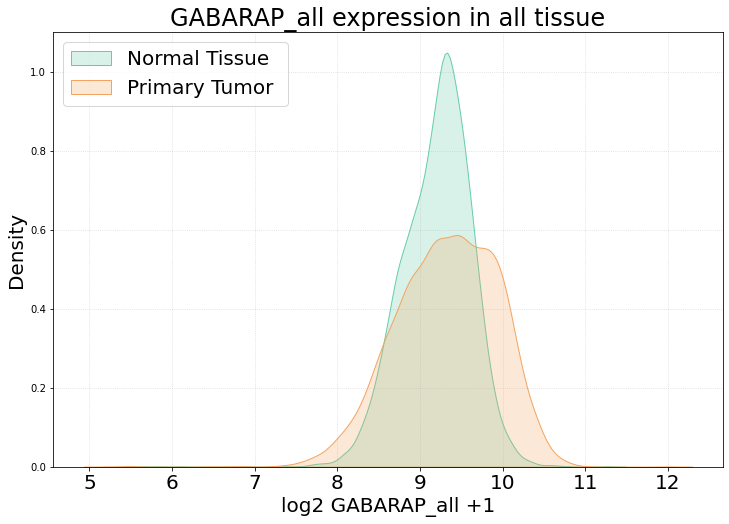

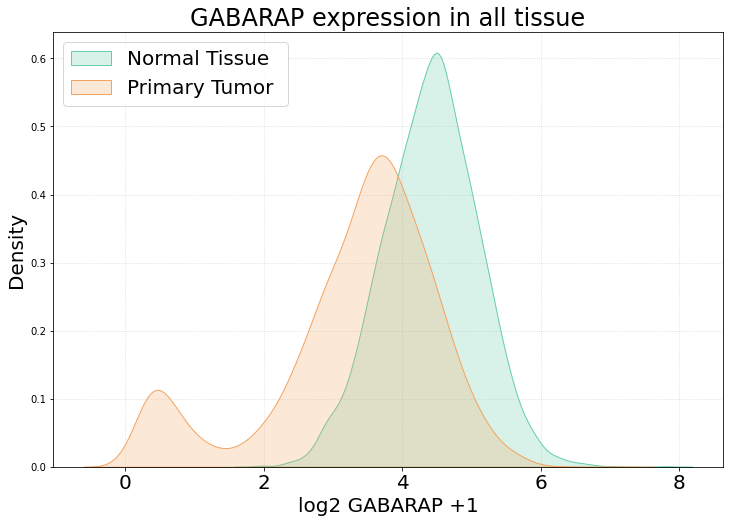

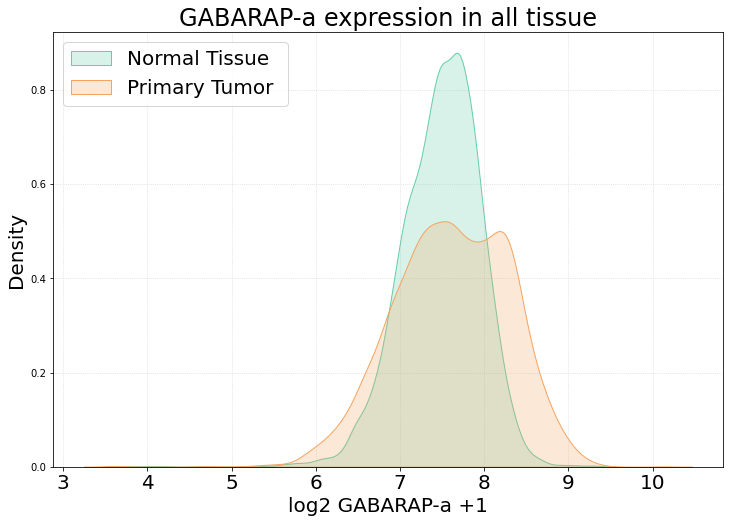

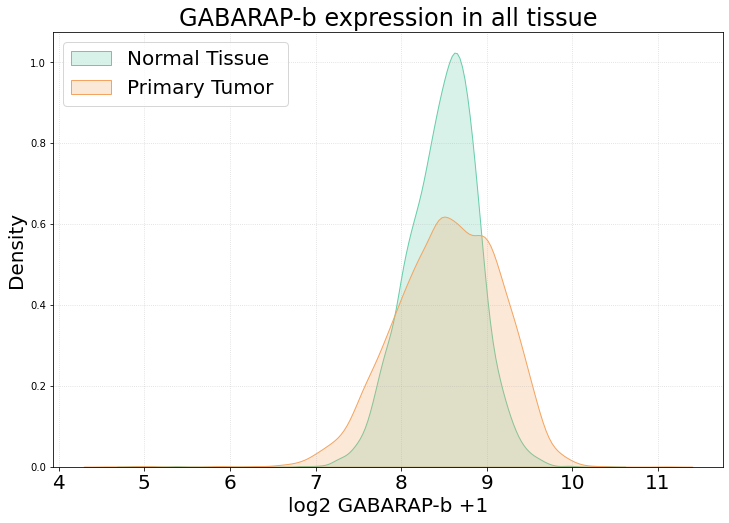

<Figure size 864x576 with 0 Axes>

In [14]:
# Distribution graph, for GABARAP, iso1 & iso2

all_dfs = [[df_GABARAP_Normal, 'in all tissue', df_GABARAP_Primary, 'all primary tumors']]

isoforms = [['log2_p1_GABARAP_total', 'GABARAP_all'], 
            ['log2_p1_GABARAP_1', 'GABARAP'], 
            ['log2_p1_GABARAP_2', 'GABARAP-a'],
            ['log2_p1_GABARAP_3', 'GABARAP-b']]

for df in all_dfs:
  for isoform in isoforms:
    xData = df[0][isoform[0]]
    x2Data = df[2][isoform[0]]

    seaborn.kdeplot(xData, color = 'mediumaquamarine', fill = True)
    seaborn.kdeplot(x2Data, color = 'sandybrown', fill = True)

    plt.xlabel('log2 '+ isoform[1]+ ' +1')
    plt.title(isoform[1]+ ' expression ' + df[1] )
    plt.legend(labels=["Normal Tissue","Primary Tumor "], loc='upper left')
    plt.grid(ls=':', alpha=0.5)
    plt.show()
    plt.clf()

## B) Percentage do not express GABARAP isoforms

In [15]:
#Percentage of patients: 
all_dfs = [[df_GABARAP_Normal, 'all normal tissue'], [df_GABARAP_Primary, 'all primary tumor']]

isoforms = [['GABARAP_all_tpm', 'GABARAP(all)'], ['GABARAP_1tpm', 'GABARAP'], 
            ['GABARAP_2tpm', 'GABARAP-a'], ['GABARAP_3tpm', 'GABARAP-b']]

for df in all_dfs:
  print(df[1])
  for isoform in isoforms:
        
    what = isoform[1]
    all = (df[0][isoform[0]]).shape
    no_exp = (df[0][isoform[0]]<0.1).sum()
    perc_no_exp = (no_exp*100)/all
    perc_no_exp = float(perc_no_exp)

    # print("The percentage of patient who do not express", QUOI, OU, "is:", round(perc_no_exp,1),'%')
    print(round(perc_no_exp,1),'% of tumor do not express', what)
  print()


all normal tissue
0.0 % of tumor do not express GABARAP(all)
0.0 % of tumor do not express GABARAP
0.0 % of tumor do not express GABARAP-a
0.0 % of tumor do not express GABARAP-b

all primary tumor
0.0 % of tumor do not express GABARAP(all)
0.5 % of tumor do not express GABARAP
0.0 % of tumor do not express GABARAP-a
0.0 % of tumor do not express GABARAP-b



In [16]:
#Percentage of patients: 
all_dfs = [[df_GABARAP_Normal, 'all normal tissue'], [df_GABARAP_Primary, 'all primary tumor']]

isoforms = [['GABARAP_all_tpm', 'GABARAP(all)'], ['GABARAP_1tpm', 'GABARAP'], 
            ['GABARAP_2tpm', 'GABARAP-a'], ['GABARAP_3tpm', 'GABARAP-b']]

df_number_exp = []
what = []
sample_type = []
who_dontexp = []
perc_noexp = []
    
for df in all_dfs:
    for isoform in isoforms:
        #save what isoform
        what.append(isoform[1])
        #save sample_type
        sample_type.append(df[1])
        #have total sample number
        all_ = (df[0][isoform[0]]).shape
        #calculate number of sample who express the isoform
        without_exp = (df[0][isoform[0]]<0.1).sum()
        who_dontexp.append(without_exp)
        #convert result to percentage
        perc_without_exp = float((without_exp*100)/all_)   
        perc_noexp.append(round(perc_without_exp,1))

        #create a dictionnary and convert to dataframe
        d = dict(Isoforms = what, who_dontexp = who_dontexp, 
                 Percentage = perc_noexp, Sample_Type = sample_type)
        df_noexpr_distrib = pandas.DataFrame.from_dict(d, orient='index')
        df_noexpr_distrib = df_noexpr_distrib.T
          
df_noexpr_distrib

,Isoforms,who_dontexp,Percentage,Sample_Type
0,GABARAP(all),0,0,all normal tissue
1,GABARAP,0,0,all normal tissue
2,GABARAP-a,0,0,all normal tissue
3,GABARAP-b,0,0,all normal tissue
4,GABARAP(all),0,0,all primary tumor
5,GABARAP,44,0.5,all primary tumor
6,GABARAP-a,0,0,all primary tumor
7,GABARAP-b,0,0,all primary tumor


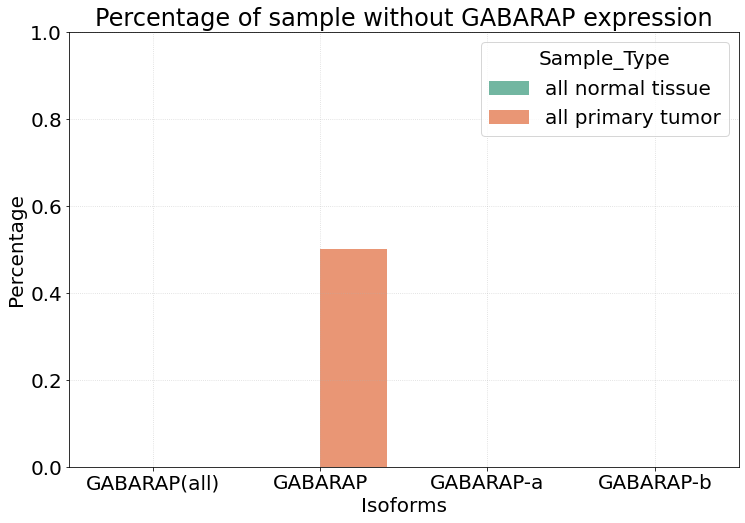

In [17]:
seaborn.barplot(data=df_noexpr_distrib, x="Isoforms", y="Percentage", hue="Sample_Type", 
                palette = 'Set2', orient = 'v')
plt.title("Percentage of sample without GABARAP expression")
plt.yticks(fontsize=20)
plt.grid(ls=':', alpha=0.5)
plt.ylim(0,1)

path = 'GABARAP/figs_GABARAP_characterisation/'
plt.savefig(output_file_directory+path+'percentage_expression.svg')

## C) Expression figures

### 1) Value TPM

In [18]:
df_GABARAP_NormPrim.iloc[:,3:7]

,GABARAP,GABARAP_1,GABARAP_2,GABARAP_3
0,11.270,7.823,9.316,10.400
18,10.760,5.788,9.279,9.984
21,10.720,5.727,9.307,9.901
29,10.610,6.334,9.109,9.729
32,10.580,6.620,8.984,9.670
...,...,...,...,...
16601,6.408,-0.771,4.546,5.872
16606,5.472,-2.680,3.568,4.957
16607,5.464,-3.816,3.497,5.014
16608,5.396,-1.617,3.473,4.839


In [19]:
# Distribution: Data preparation + graph
Data = df_GABARAP_NormPrim
info = 'all tissue'

shape = Data.shape
shape = shape[0]
print(shape)

#select the sample type column
sample_type = {'sample_type':[Data.iloc[:,1][i]
  for i in range(0, shape)]}

#convert to df, and copy it 3 times
sample_typedf = pandas.DataFrame(sample_type)
sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf,sample_typedf])
sample_typedf.reset_index(drop=True, inplace=True)

# Y for expression value 
y = {'y':[Data.iloc[:,j][i]
  for j in range(3,7)
    for i in range(0, shape)]}

#create df with Y 
data_distrib = pandas.DataFrame(y)

# X for GABARAP/iso1/iso2/iso3                            
data_distrib.loc[:shape,'x'] = 'GABARAP_all'
data_distrib.loc[shape: shape*2,'x'] = 'GABARAP'
data_distrib.loc[shape*2:shape*3,'x'] = 'GABARAP-a'
data_distrib.loc[shape*3:,'x'] = 'GABARAP-b'

# Will be used for Hue
data_distrib['Sample Type'] = sample_typedf['sample_type']

#graph
seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.45, kind="box", palette = 'Set2', data = data_distrib, 
              boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)

plt.grid(ls=':', alpha=0.5)
plt.ylabel('Expression of GABARAP (log2 TPM)')
plt.xlabel('')
plt.xticks(rotation = 35)
plt.title('GABARAP expression in '+ info, x=.55)

#save
path = 'GABARAP/figs_GABARAP_characterisation/'
plt.savefig(output_file_directory+path+'GABARAP_exp_alltissue.svg')

13925


KeyError: 1

In [ ]:
#Distribution: Stats for all 

all_dfs = [[df_GABARAP_Normal, 'all normal tissue', df_GABARAP_Primary, 'all primary tumors']]

isoforms = ['GABARAP', 'GABARAP_1', 'GABARAP_2', 'GABARAP_3']

for df in all_dfs:
  for isoform in isoforms:

    n1 = "{:.3f}".format(numpy.median(df[0][isoform]))
    n2 = "{:.3f}".format(numpy.median(df[2][isoform]))

    # Mann-Whitney analysis 
    statistic, pvalue = scipy.stats.mannwhitneyu(df[0][isoform], df[2][isoform])
    Pvalue = "{:.3E}".format(pvalue)
    print("the pvalue between", df[1]+'('+n1+')', "and", df[3]+'('+n2+')', "for", isoform, 'is', Pvalue)
  print()


In [ ]:
#median brut file to compare 
print(df_GABARAP_NormPrim['GABARAP'].mean())
print(df_GABARAP_NormPrim['GABARAP_1'].mean())
print(df_GABARAP_NormPrim['GABARAP_2'].mean())
print(df_GABARAP_NormPrim['GABARAP_3'].mean())

### 2) Normalized

In [ ]:
df_GABARAP_NormPrim.iloc[:,19:22]

In [ ]:
len(df_GABARAP_NormPrim.columns)

In [ ]:
# Distribution: Data preparation + graph
df_GABARAP_NormPrim.iloc[:,22:25].head(2)

In [ ]:
# NORMALiZED Distribution: Data preparation + graph
# Distribution: Data preparation + graph
Data = df_GABARAP_NormPrim
info = 'all tissue'

shape = Data.shape
shape = shape[0]
print(shape)

#select the sample type column
sample_type = {'sample_type':[Data.iloc[:,1][i]
  for i in range(0, shape)]}

#convert to df, and copy it 3 times
sample_typedf = pandas.DataFrame(sample_type)
sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf,sample_typedf])
sample_typedf.reset_index(drop=True, inplace=True)

# Y for expression value 
y = {'y':[Data.iloc[:,j][i]
  for j in range(22,25)
    for i in range(0, shape)]}

#create df with Y 
data_distrib = pandas.DataFrame(y)

# X for GABARAP/iso1/iso2                              
data_distrib.loc[:shape,'x'] = 'GABARAP\n/GABARAP_all'
data_distrib.loc[shape: shape*2,'x'] = 'GABARAP-a\n/GABARAP_all'
data_distrib.loc[shape*2:,'x'] = 'GABARAP-b\n/GABARAP_all'

# Will be used for Hue
data_distrib['Sample Type'] = sample_typedf['sample_type']

#graph
seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.25, kind="box", palette = 'Set2', data = data_distrib, 
              boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)

plt.ylabel('expression norm. on \n GABARAP_all in log2 TPM')
plt.xlabel('')
plt.title('GABARAP proportion in '+ info, x=0.55)
plt.xticks(rotation = 35)

#save graph
path = 'GABARAP/figs_GABARAP_characterisation/'
plt.savefig(output_file_directory+path+'prop_alltissue.svg')

In [ ]:
#NORMALIZED Distribution: Stats for all 

all_dfs = [[df_GABARAP_Normal, 'all normal tissue', df_GABARAP_Primary, 'all primary tumors']]

isoforms = ['GABARAP_1lognorm', 'GABARAP_2lognorm', 'GABARAP_3lognorm']
print('NORMALIZED')

for df in all_dfs:
  for isoform in isoforms:

    n1 = "{:.3f}".format(numpy.median(df[0][isoform]))
    n2 = "{:.3f}".format(numpy.median(df[2][isoform]))

    # Mann-Whitney analysis 
    statistic, pvalue = scipy.stats.mannwhitneyu(df[0][isoform], df[2][isoform])
    Pvalue = "{:.3E}".format(pvalue)
    print("the pvalue between", df[1]+'('+n1+')', "and", df[3]+'('+n2+')', "for", isoform, 'is', Pvalue)
  print()


In [ ]:
#same but tpm!

In [ ]:
# NORMALiZED Distribution: Data preparation + graph
# Distribution: Data preparation + graph
Data = df_GABARAP_NormPrim
info = 'all tissue'

shape = Data.shape
shape = shape[0]
print(shape)

#select the sample type column
sample_type = {'sample_type':[Data.iloc[:,1][i]
  for i in range(0, shape)]}

#convert to df, and copy it 3 times
sample_typedf = pandas.DataFrame(sample_type)
sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf,sample_typedf])
sample_typedf.reset_index(drop=True, inplace=True)

# Y for expression value 
y = {'y':[Data.iloc[:,j][i]
  for j in range(19,22)
    for i in range(0, shape)]}


#create df with Y 
data_distrib = pandas.DataFrame(y)

# X for GABARAP/iso1/iso2                              
data_distrib.loc[:shape,'x'] = 'GABARAP\n/GABARAP_all'
data_distrib.loc[shape: shape*2,'x'] = 'GABARAP-a\n/GABARAP_all'
data_distrib.loc[shape*2:,'x'] = 'GABARAP-b\n/GABARAP_all'

# Will be used for Hue
data_distrib['Sample Type'] = sample_typedf['sample_type']

#graph
seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.25, kind="box", palette = 'Set2', data = data_distrib, 
              boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)

plt.ylabel('expression norm. on \n GABARAP_all in TPM')
plt.xlabel('')
plt.title('GABARAP proportion in '+ info, x=0.55)
plt.xticks(rotation = 35)
plt.grid(ls=':', alpha=0.5)

#save graph
path = 'GABARAP/figs_GABARAP_characterisation/'
plt.savefig(output_file_directory+path+'prop_alltissue.svg')

In [ ]:
#NORMALIZED Distribution: Stats for all 

all_dfs = [[df_GABARAP_Normal, 'all normal tissue', df_GABARAP_Primary, 'all primary tumors']]

isoforms = ['GABARAP_1norm', 'GABARAP_2norm', 'GABARAP_3norm']
print('NORMALIZED')

for df in all_dfs:
  for isoform in isoforms:

    n1 = "{:.3f}".format(numpy.median(df[0][isoform]))
    n2 = "{:.3f}".format(numpy.median(df[2][isoform]))

    # Mann-Whitney analysis 
    statistic, pvalue = scipy.stats.mannwhitneyu(df[0][isoform], df[2][isoform])
    Pvalue = "{:.3E}".format(pvalue)
    print("the pvalue between", df[1]+'('+n1+')', "and", df[3]+'('+n2+')', "for", isoform, 'is', Pvalue)
  print()


## D) Correlation between the two isoforms

In [ ]:
df_GABARAP_Primary[df_GABARAP_Primary['GABARAP_1tpm'] > 55 ]

In [ ]:
#isoform correlation in all tissue 
color1 = '#72B6A1'
color2 = '#e99675'

#remove extremities
df_GABARAP_Primary2 = df_GABARAP_Primary[df_GABARAP_Primary['GABARAP_1tpm'] < 55 ]
df_GABARAP_Primary2 = df_GABARAP_Primary2[df_GABARAP_Primary2['GABARAP_2tpm'] < 440 ]
df_GABARAP_Primary2 = df_GABARAP_Primary2[df_GABARAP_Primary2['GABARAP_3tpm'] < 800 ]

print('primary')
print("shape:",df_GABARAP_Primary.shape)
print("shape after removing extrem dots:",df_GABARAP_Primary2.shape)
print()
df_GABARAP_Normal2 = df_GABARAP_Normal[df_GABARAP_Normal['GABARAP_1tpm'] < 75 ]
df_GABARAP_Normal2 = df_GABARAP_Normal2[df_GABARAP_Normal2['GABARAP_2tpm'] < 350 ]
df_GABARAP_Normal2 = df_GABARAP_Normal2[df_GABARAP_Normal2['GABARAP_3tpm'] < 900 ]

print('normal')
print("shape:",df_GABARAP_Normal.shape)
print("shape after removing extrem dots:",df_GABARAP_Normal2.shape)

tissues = [[df_GABARAP_Normal2, "normal tissues", color1], 
           [df_GABARAP_Primary2, "primary tumors", color2]]

for tissue in tissues: 
    x = tissue[0]['GABARAP_1tpm'].to_list()
    y = tissue[0]['GABARAP_2tpm'].to_list()
    z = tissue[0]['GABARAP_3tpm'].to_list()

    r_value, p_value = scipy.stats.pearsonr(x, y)
    print("The correlation between iso1 and iso2 in",tissue[1],"is:", r_value, p_value)

    seaborn.regplot(x=x,y=y, x_bins=800, x_ci = 0, marker="+", label = tissue[1], color = tissue[2])
    seaborn.regplot(x=[],y=[], marker=" ", label= 'rvalue: '+str(round(r_value,3))+ "\npvalue <0.05")

    name = "Correlation between the two isoforms in "+  tissue[1]
    plt.title(name)
    plt.legend()
    plt.grid(ls=':', alpha=0.5)
    plt.xlabel("GABARAP expression in tpm")
    plt.ylabel('GABARAP-a expression in tpm')
    plt.show()
    plt.clf()

    r_value, p_value = scipy.stats.pearsonr(x, z)
    print("The correlation between iso1 and iso3 in",tissue[1],"is:", r_value, p_value)

    seaborn.regplot(x=x,y=z, x_bins=800, x_ci = 0, marker="+", label = tissue[1], color = tissue[2])
    seaborn.regplot(x=[],y=[], marker=" ", label= 'rvalue: '+str(round(r_value,3))+ "\npvalue <0.05")

    name = "Correlation between the two isoforms in "+  tissue[1]
    plt.title(name)
    plt.legend()
    plt.grid(ls=':', alpha=0.5)
    plt.xlabel("GABARAP expression in tpm")
    plt.ylabel('GABARAP-b expression in tpm')
    plt.show()
    plt.clf()
    print()

    r_value, p_value = scipy.stats.pearsonr(y, z)
    print("The correlation between iso1 and iso3 in",tissue[1],"is:", r_value, p_value)

    seaborn.regplot(x=y,y=z, x_bins=800, x_ci = 0, marker="+", label = tissue[1], color = tissue[2])
    seaborn.regplot(x=[],y=[], marker=" ", label= 'rvalue: '+str(round(r_value,3))+ "\npvalue <0.05")

    name = "Correlation between the two isoforms in "+  tissue[1]
    plt.title(name)
    plt.legend()
    plt.grid(ls=':', alpha=0.5)
    plt.xlabel("GABARAP-a expression in tpm")
    plt.ylabel('GABARAP-b expression in tpm')
    plt.show()
    plt.clf()
    print()
